# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTOrch before.

But how do you get that into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**

* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import pandas as pd
import torch
from contourpy.util.data import simple
from fontTools.misc.timeTools import epoch_diff
from torch import nn
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

print(torch.__version__)

2.5.1


In [2]:
# Setup device-agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))
device

device(type='mps')

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Why do this?

When starting out ML Projects, it's important to try things on a small scale and then increase the scale when necessery.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.exists():
    print(f"{image_path} already exists, skipping download.")
else:
    print(f"Downloading {image_path} ...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(req.content)

# Unzip dataset
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    print("Extracting pizza, steak, sushi data...")
    zip_file.extractall(image_path)

data/pizza_steak_sushi already exists, skipping download.
Extracting pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dir_path, dir_names, filenames in os.walk(data_path):
        print(f"There are {len(dir_names)} directories and {len(filenames)} images in'{dir_path}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 1 images in'data'.
There are 1 directories and 0 images in'data/FashionMNIST'.
There are 0 directories and 8 images in'data/FashionMNIST/raw'.
There are 2 directories and 0 images in'data/pizza_steak_sushi'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

1. Let's write some code to Get all the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image ith Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image size: (512, 512)


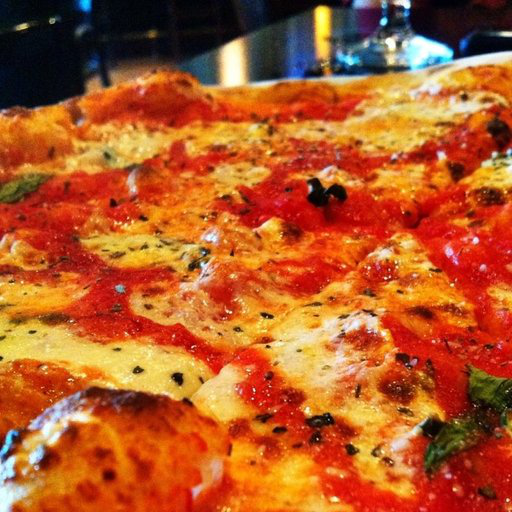

In [7]:
import random
from PIL import Image

# Set the Random seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# 1. Get all teh image paths
image_paths_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image paths
random_image_path = random.choice(image_paths_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image size: {img.size}")
img

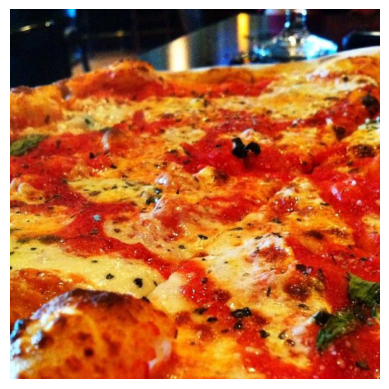

In [8]:
# Trying to visualize the image with matplotlib...
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off');

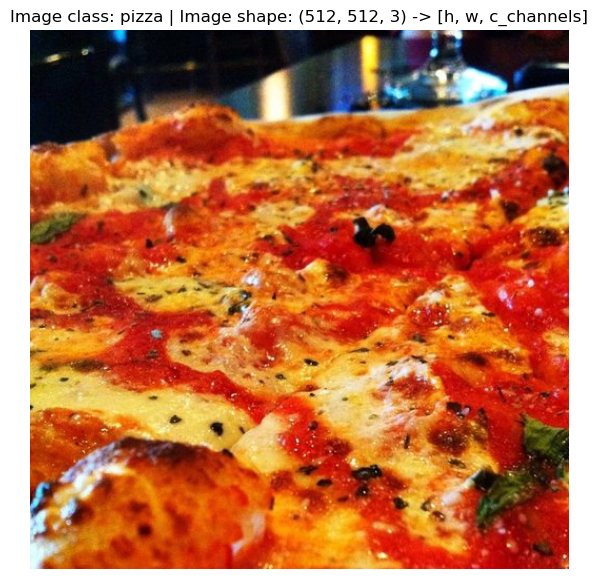

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [h, w, c_channels]")
plt.axis('off');

In [10]:
img_as_array

array([[[  7,  18,  38],
        [  5,  16,  34],
        [  2,  13,  31],
        ...,
        [ 18,   7,  11],
        [ 12,   6,   8],
        [  8,   4,   5]],

       [[  2,  13,  33],
        [  2,  13,  31],
        [  2,  13,  31],
        ...,
        [ 18,   9,  10],
        [ 17,  11,  13],
        [ 16,  12,  13]],

       [[  0,  11,  31],
        [  1,  12,  30],
        [  3,  14,  32],
        ...,
        [ 17,   8,   9],
        [ 16,  10,  12],
        [ 15,  11,  12]],

       ...,

       [[226, 249, 255],
        [229, 253, 255],
        [229, 255, 254],
        ...,
        [250, 149,  95],
        [240, 139,  83],
        [234, 130,  75]],

       [[220, 247, 254],
        [224, 252, 255],
        [226, 255, 253],
        ...,
        [236, 133,  88],
        [195,  88,  42],
        [170,  62,  16]],

       [[218, 247, 255],
        [223, 252, 255],
        [224, 254, 254],
        ...,
        [255, 157, 116],
        [208,  99,  60],
        [166,  52,  15]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case numerical representation of our images).
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms helps you get your images ready to be used with a model/perform data augmentation - https://docs.pytorch.org/vision/stable/transforms.html

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),

    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.0157, 0.0157, 0.0118,  ..., 0.2314, 0.1922, 0.1020],
         [0.0157, 0.0157, 0.0157,  ..., 0.1137, 0.1059, 0.1216],
         [0.0157, 0.0235, 0.0902,  ..., 0.1098, 0.1255, 0.1608],
         ...,
         [0.8510, 0.8235, 0.8000,  ..., 0.4314, 0.6353, 0.6941],
         [0.8667, 0.8392, 0.7922,  ..., 0.4824, 0.6235, 0.7412],
         [0.8627, 0.7373, 0.7255,  ..., 0.6627, 0.6549, 0.8000]],

        [[0.0588, 0.0510, 0.0392,  ..., 0.0510, 0.0471, 0.0392],
         [0.0549, 0.0471, 0.0431,  ..., 0.0431, 0.0431, 0.0549],
         [0.0667, 0.0706, 0.1176,  ..., 0.0510, 0.0431, 0.0510],
         ...,
         [0.9529, 0.8824, 0.8157,  ..., 0.1098, 0.0627, 0.0627],
         [0.9804, 0.8510, 0.6353,  ..., 0.0667, 0.0824, 0.2392],
         [0.9412, 0.5451, 0.3176,  ..., 0.0745, 0.0980, 0.3098]],

        [[0.1176, 0.0745, 0.0667,  ..., 0.0588, 0.0510, 0.0392],
         [0.1137, 0.0863, 0.0784,  ..., 0.0431, 0.0392, 0.0510],
         [0.0941, 0.0941, 0.1255,  ..., 0.0588, 0.0510, 0.

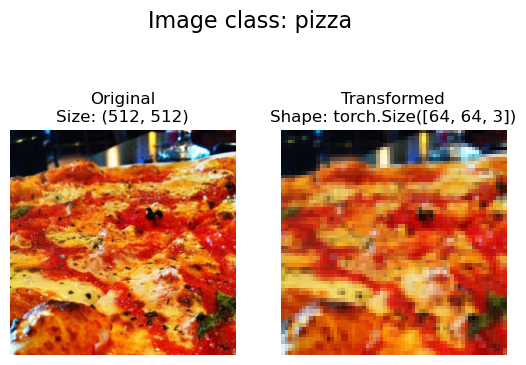

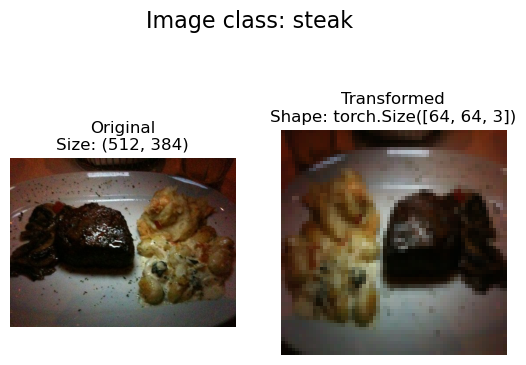

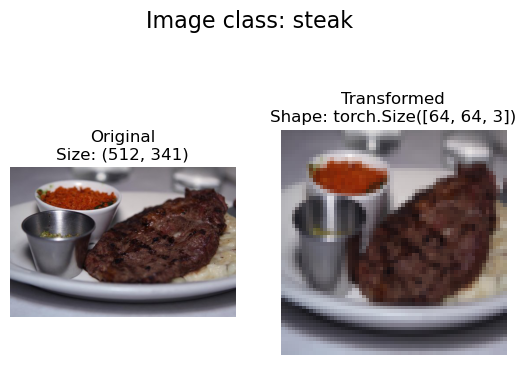

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms them then plots the original and transformed version.
    :param image_paths:
    :param transform:
    :param n:
    :param seed:
    :return:
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis('off')

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # Note we will need to change the shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_paths_list,
                        transform=data_transform,
                        n=3,
                        seed=RANDOM_SEED)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` -
https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check teh lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
# Index on the train_data Dataset to get a single image and label
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [22]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [c_channels, h, w]
Permute shape: torch.Size([64, 64, 3]) - > [h, w, c_channels]


Text(0.5, 1.0, 'pizza')

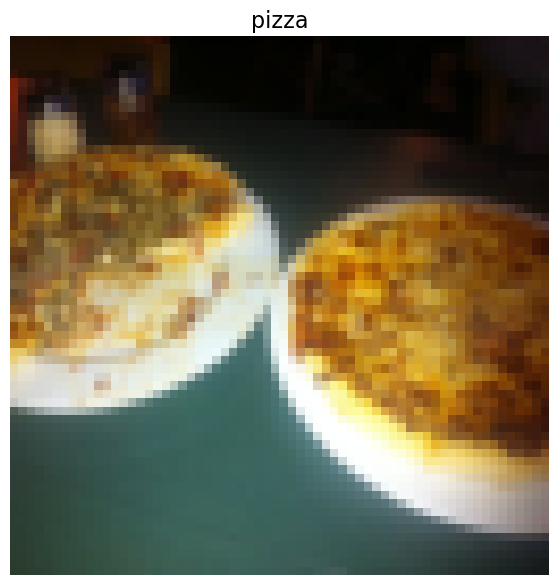

In [23]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [c_channels, h, w]")
print(f"Permute shape: {img_permute.shape} - > [h, w, c_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=16)

In [24]:
class_names[label]

'pizza'

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`s into iterables, and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [25]:
import os
os.cpu_count()

8

In [26]:
# turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16a77ec60>,
 <torch.utils.data.dataloader.DataLoader at 0x16a791310>)

In [27]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [28]:
img, label = next(iter(train_dataloader))

# Batch size will be now 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, c_channels, h, w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, c_channels, h, w]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros :
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [29]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from typing import Tuple, Dict, List

In [30]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names `os.scandir()` to traverse a target directory (ideally th directory is in standard image classification format)
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [31]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in os.scandir(target_directory)])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [32]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int ]]:
    """
    Finds the class folder names in a target directory
    :param directory:
    :return:
    """
    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    # 3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [33]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to 'load_images()', this function will open an image
5. Overwrite the `__len()__` method to return the lenath of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an
index

In [34]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, target_dir: str, transform=None):
        # 3. Create class attributes
        # Get all the images paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """
        Loads an image via a path and returns it as a PIL Image
        :param index: the index of the image
        :return:
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite .__len__()
    def __len__(self):
        """
        Returns the total number of images in the dataset
        :return: the total number of images
        """
        return len(self.paths)

    # 6. Overwrite .__getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieves an image at a specific index
        :param index: The index of the image
        :return:
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_idx[class_name]

        if self.transform:
            img = self.transform(img)
        return img, class_index

In [35]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [36]:
# Create a transform
from torchvision import transforms, datasets
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [37]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transforms
)
test_data_custom = ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transforms
)

In [38]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x16a7ee000>,
 <__main__.ImageFolderCustom at 0x16a76aea0>)

In [39]:
len(train_data), len(train_data_custom)

(225, 225)

In [40]:
len(test_data), len(test_data_custom)

(75, 75)

In [41]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [42]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [43]:
# Check for equality between original-ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to at 10.
3. Set the random seed for reproducibility
4. Set a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [44]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None) -> None:
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print("For display perposes, n should be over 10.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(train_data_custom)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [c_channels, h, w] -> [h, w, c_channels]

        # Plot adjusted samples
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

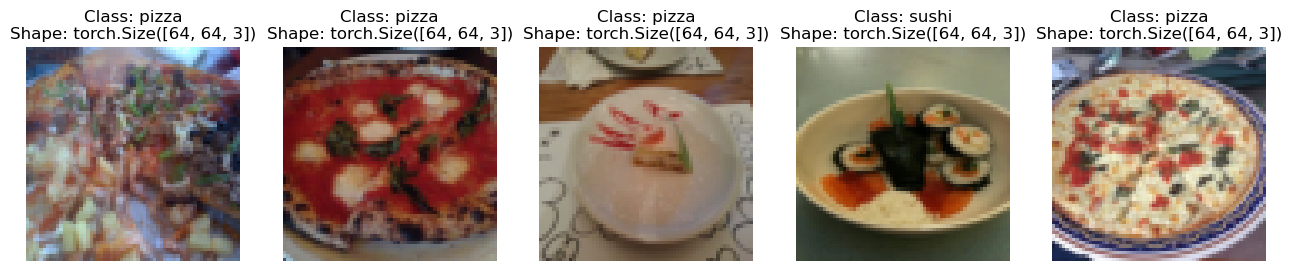

In [45]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed = None)

For display perposes, n should be over 10.


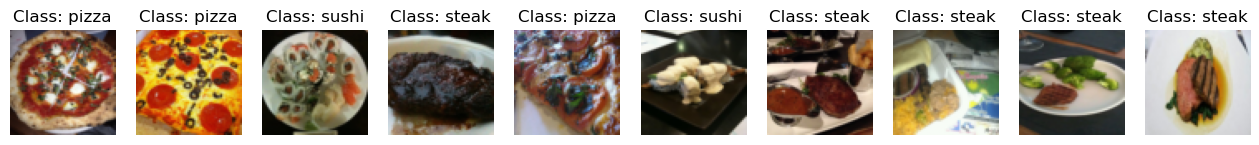

In [46]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custum loaded images into `DataLoader`'s

In [47]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x16a62f740>,
 <torch.utils.data.dataloader.DataLoader at 0x14010d5b0>)

In [48]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transformation (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

THis practice hopefully results into a model that's nore generalizable to unseen data

In [49]:
# Let's look at trivial-augment -
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [50]:
# Get all the image paths
image_paths_list = list(image_path.glob("*/*/*.jpg"))
image_paths_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

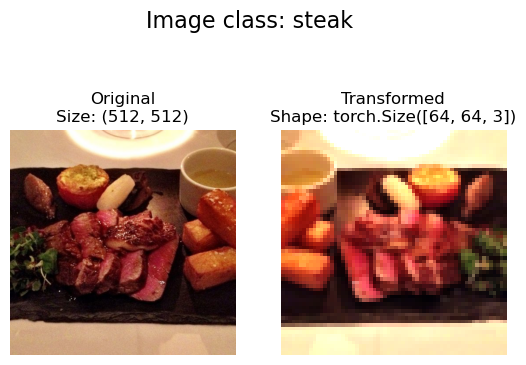

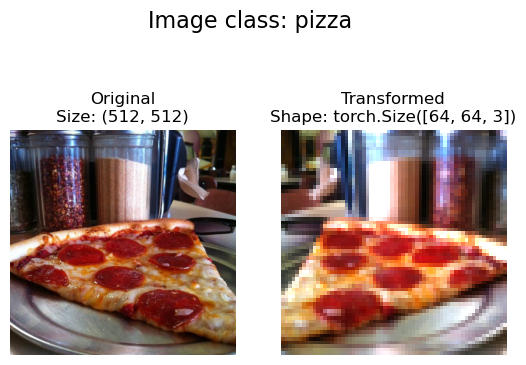

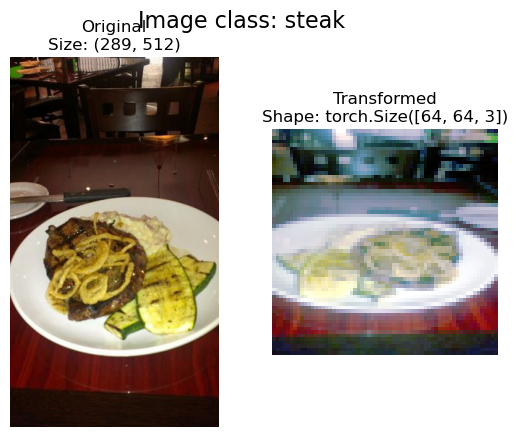

In [51]:
plot_transformed_images(
    image_paths=image_paths_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG: without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating  transforms and loading data for Model 0

In [52]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [53]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [54]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG architecture from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, in_channels=3, hidden_channels=64, output_channels=3) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is the same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is the same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1690, out_features=output_channels)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # return self.classifier(x)
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [55]:
torch.manual_seed(RANDOM_SEED)
model_0 = TinyVGG(in_channels=3, hidden_channels=10, output_channels=len(class_names))
model_0.to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [56]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)
model_0(image_batch)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0999e-02,  1.2870e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8270e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [57]:
from torchinfo import summary
summary(model_0, input_size=(32, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [58]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.to(device)
    loss_fn.to(device)

    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    for batch, (img, label) in enumerate(dataloader):
        # Send the data to target device
        img, label = img.to(device), label.to(device)

        # 1. Forward pass
        logits = model(img)

        # 2. Calculate the loss
        loss = loss_fn(logits, label)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy matric
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == label).sum().item()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc

In [59]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    """
    Performs a testing with a model trying to learn on `dataloader`
    :param model: The model to test
    :param dataloader: The dataloader to test on
    :param loss_fn: The loss function
    :param acc_fn: The accuracy function
    :param device: The device to train on
    :return: The test loss and accuracy
    """
    model.to(device)
    loss_fn.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Put model in eval mode
    model.eval()

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X_test, y_test in dataloader:
            # Send data to the target device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # 1. Forward pass
            test_pred = model(X_test)

            # 2. Calculate the test loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test).item()

            #  3. Calculate the accuracy
            test_acc += (test_pred.argmax(dim=1) == y_test).sum().item()
        # Calculate the test loss average per batch
        test_loss /= len(dataloader)

        # Calculate the test accuracy average per batch
        test_acc /= len(dataloader.dataset)

    # Print out what's happening
    # print(f'Test loss: {test_loss:.4f}, test accuracy: {test_acc*100:.2f}%')
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [60]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 100,
          device: torch.device = device):

    # 2. Create empty results dictionary
    results = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc*100:.2f}% | Test loss {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['train_acc'].append(train_acc)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [61]:
from torch import optim

# Set random seeds
torch.manual_seed(RANDOM_SEED)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(in_channels=3, hidden_channels=10, output_channels=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Training time: {end_time-start_time:.2f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20 | Train loss: 1.0861 | Train accuracy: 41.78% | Test loss 1.0539 | Test accuracy: 38.67%
Epoch: 2/20 | Train loss: 1.0101 | Train accuracy: 50.22% | Test loss 0.9921 | Test accuracy: 42.67%
Epoch: 3/20 | Train loss: 0.9727 | Train accuracy: 55.11% | Test loss 0.9970 | Test accuracy: 53.33%
Epoch: 4/20 | Train loss: 0.9198 | Train accuracy: 56.44% | Test loss 0.9816 | Test accuracy: 42.67%
Epoch: 5/20 | Train loss: 0.8946 | Train accuracy: 58.67% | Test loss 0.9889 | Test accuracy: 50.67%


KeyboardInterrupt: 

In [68]:
model_0_results

,train_loss,test_loss,train_acc,test_acc
0,1.086137,1.053921,0.417778,0.386667
1,1.010147,0.992120,0.502222,0.426667
2,0.972703,0.996966,0.551111,0.533333
3,0.919801,0.981645,0.564444,0.426667
4,0.894610,0.988921,0.586667,0.506667
5,0.871189,1.007357,0.604444,0.426667
6,0.833084,1.067130,0.595556,0.426667
7,0.835489,0.985878,0.613333,0.506667
8,0.808256,0.937362,0.657778,0.506667
9,0.814361,0.988200,0.631111,0.546667


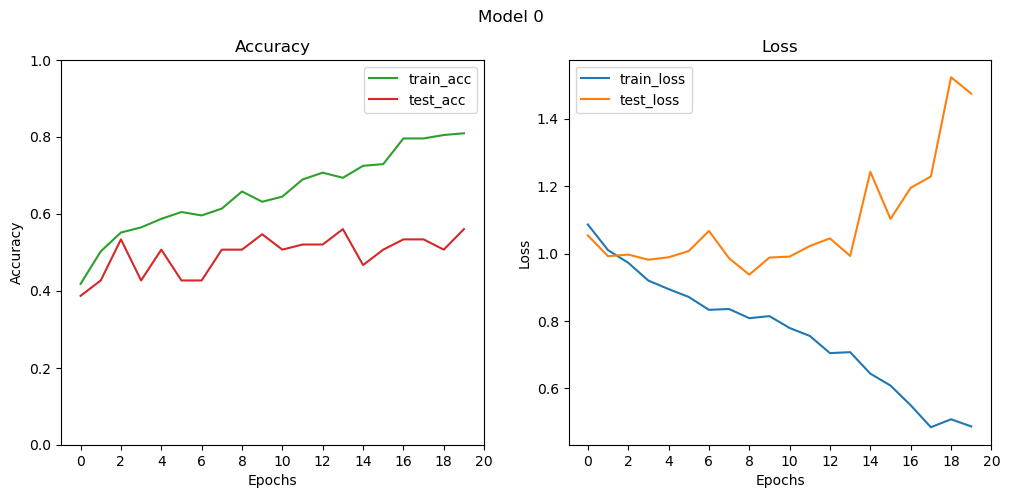

In [102]:
import pandas as pd
model_0_results = pd.DataFrame(model_0_results)

axes = model_0_results.plot(
    subplots=[('train_acc', 'test_acc'), ('train_loss', 'test_loss')],
    layout=(1, 2),   # side by side
    figsize=(12, 5),
    title='Model 0',
    xlabel='Epochs',
    xticks= list(filter(lambda epoch_diff: epoch_diff%2==0, range(0,NUM_EPOCHS+1)))
)

# axes is a 2D array because of layout=(1, 2)
ax1, ax2 = axes[0]
ax1.set(ylim=(0, 1), title="Accuracy", ylabel="Accuracy")
ax2.set(title="Loss", ylabel="Loss");


The model is overfitting successfully (testing loss is wayyyy too high lol)

In [81]:
## NOT NEEDED (Already done more elegantly)
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """
    Plots the loss curves using matplotlib
    :param results:
    :return:
    """
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(loss))

    # Setup a plot
    plt.figure(figsize=(12, 5))
    plt.suptitle("Model_0")

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [67]:
plot_loss_curves(model_0_results)

NameError: name 'model_0_results' is not defined

In [74]:
## try 2?
import torch
from torch import nn

class TinyVGG2(nn.Module):
    """
    Improved TinyVGG architecture:
    - Conv blocks with padding to preserve spatial dims
    - Global Average Pooling instead of flattening huge feature maps
    - Dropout before final linear layer
    """
    def __init__(self, in_channels=3, hidden_channels=64, output_channels=3, dropout_p=0.5):
        super().__init__()

        # First conv block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # halves H, W
        )

        # self.conv_block_middle = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(in_features, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, num_classes)
        # )


        # Second conv block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels*2, hidden_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # halves H, W
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),               # (B, C, 1, 1)
            nn.Flatten(),                          # (B, C)
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_channels*2, output_channels)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [76]:
model_0_edited = TinyVGG2(in_channels=3, hidden_channels=64, output_channels=len(class_names)).to(device)

# Standard ImageNet normalization // experimenting
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                          saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform2,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform2,
                                 target_transform=None)

train_dataloader2 = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)
test_dataloader2 = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=4)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0_edited.parameters(), lr=1e-4)

In [77]:
device

device(type='mps')

In [79]:
model_0_results2 = train(model=model_0_edited,
                        train_dataloader=train_dataloader2,
                        test_dataloader=test_dataloader2,
                        optimizer=optimizer,
                        epochs=10,
                        device=torch.device("mps"))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train loss: 1.0928 | Train accuracy: 31.11% | Test loss 1.0952 | Test accuracy: 34.67%
Epoch: 2/10 | Train loss: 1.0992 | Train accuracy: 40.00% | Test loss 1.0992 | Test accuracy: 30.67%
Epoch: 3/10 | Train loss: 1.0925 | Train accuracy: 42.67% | Test loss 1.0939 | Test accuracy: 30.67%
Epoch: 4/10 | Train loss: 1.0620 | Train accuracy: 46.67% | Test loss 1.0867 | Test accuracy: 30.67%
Epoch: 5/10 | Train loss: 1.0877 | Train accuracy: 41.78% | Test loss 1.0951 | Test accuracy: 33.33%
Epoch: 6/10 | Train loss: 1.0655 | Train accuracy: 42.22% | Test loss 1.1047 | Test accuracy: 34.67%
Epoch: 7/10 | Train loss: 1.0862 | Train accuracy: 45.33% | Test loss 1.1140 | Test accuracy: 32.00%
Epoch: 8/10 | Train loss: 1.0265 | Train accuracy: 52.89% | Test loss 1.0981 | Test accuracy: 30.67%
Epoch: 9/10 | Train loss: 1.0234 | Train accuracy: 47.56% | Test loss 1.1012 | Test accuracy: 32.00%
Epoch: 10/10 | Train loss: 1.0554 | Train accuracy: 49.33% | Test loss 1.1113 | Test accura

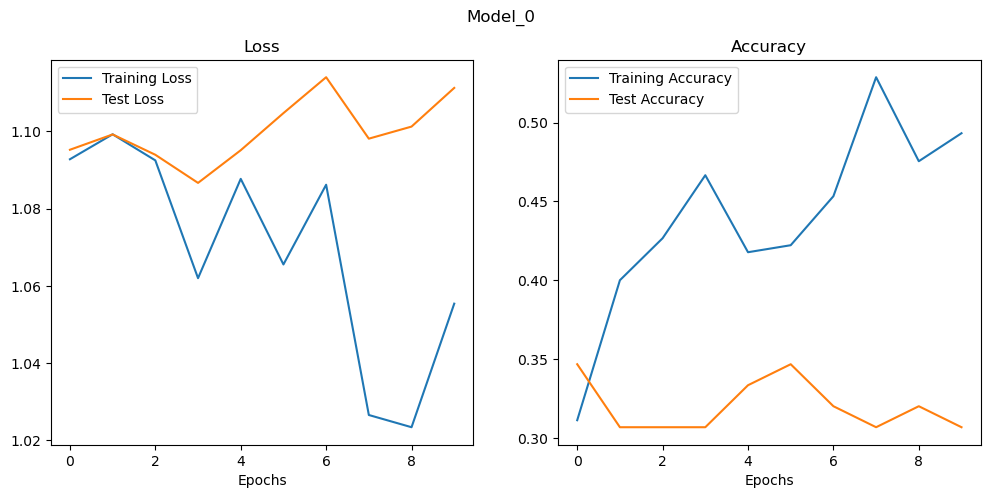

In [82]:
plot_loss_curves(model_0_results2)

<h1>Badd (overfitting) 😃

## 8. What should an ideal loss curve look like

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

__Copied from the course detailed notebook:__

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

In [1]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

update_progress(video_index=200, done=False)

Updated progress report. 
Video: 200. What Is Experiment Tracking and Why Track Experiments 
Duration: 7m 
Status: Not done 
Date: N/A 
Section progress: 
Section : 9.PyTorch Experiment Tracking
Status  : 22 videos remaining, 3h 11m to finish the section
Progress:   0%|                               0/22


In [3]:
progress_report_print()

NameError: name 'progress_report_print' is not defined